In [1]:
#Imports necessary libraries
import pandas as pd
import sqlite3
from pandasql import sqldf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
#import DataBase, activate cursor
con = sqlite3.connect('movie_project.db')
c = con.cursor()

In [3]:
#create df from db with relevant columns
c.execute('''select original_title, primary_title, primary_name, production_budget, worldwide_gross, genres, category, runtime_minutes, averagerating, numvotes, release_date
                     from tn_movie_budgets tmb
                     join imdb_title_basics itb
                     on tmb.movie == itb.primary_title
                     join imdb_title_principles
                     using(tconst)
                     join imdb_title_ratings
                     using (tconst)
                     join imdb_name_basics
                     using(nconst)''')
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]

In [4]:
#create formating function
def reformat_series_as_float(df_series):
    df_series = df_series.str.replace(r'[^0-9]+', '')
    df_series = df_series.astype('float64')
    return df_series
#reformat all numbers as floats
df['production_budget'] = reformat_series_as_float(df['production_budget'])
df['worldwide_gross'] = reformat_series_as_float(df['worldwide_gross'])
df['runtime_minutes'] = reformat_series_as_float(df['runtime_minutes'])

In [5]:
#create new column for the month of release
df['release_month'] = df['release_date'].apply(lambda x: x[:3])

In [6]:
#create profit column
df['profit'] = df['worldwide_gross'] - df['production_budget']

In [7]:
#introduce pandas query function
pysqldf = lambda q: sqldf(q, globals())

In [8]:
#Creates table of Actors and average profit with number of movies
actors = pysqldf('''select primary_name, avg(profit) / 1000000 as avg_profit, count(primary_name) as num_movies
           from df
           group by primary_name
           having count(primary_title) > 10 and (category == 'actor' or category == 'actress')  
           order by avg(profit) desc
           limit 20''')

[Text(0, 0.5, 'Profit in Millions'),
 Text(0.5, 0, 'Actor Names'),
 Text(0.5, 1.0, 'Most Profitable Actors')]

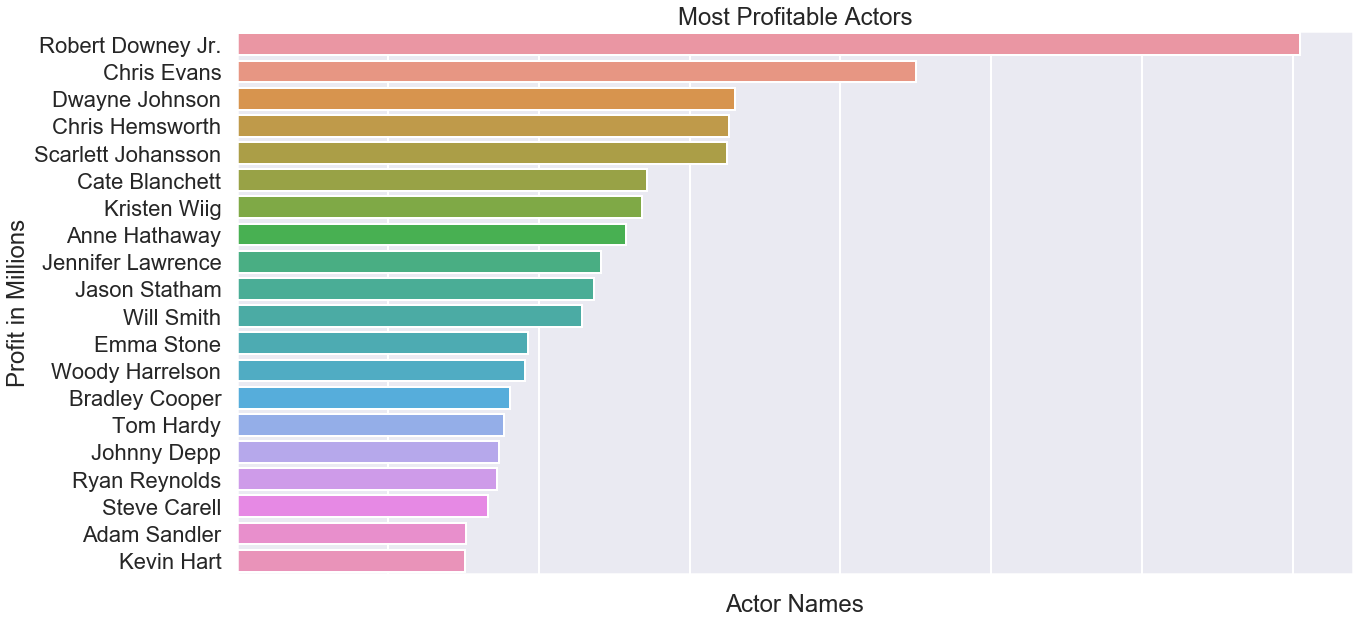

In [9]:
#Charts most profitable actors
sns.set(style = 'darkgrid', context = 'poster')
plt.figure(figsize=(20,10))
actorsChart = sns.barplot(data=actors, y='primary_name', x='avg_profit')
actorsChart.set_xticklabels(actorsChart.get_xticklabels(), rotation=45, horizontalalignment='right')
actorsChart.set(title = 'Most Profitable Actors', xlabel='Actor Names', ylabel='Profit in Millions')

In [10]:
#genre table
genre_table = df
print("genre_table shape: " + str(genre_table.shape))
print("genre_table columns: " + str(genre_table.columns))

genre_table shape: (27145, 13)
genre_table columns: Index(['original_title', 'primary_title', 'primary_name', 'production_budget',
       'worldwide_gross', 'genres', 'category', 'runtime_minutes',
       'averagerating', 'numvotes', 'release_date', 'release_month', 'profit'],
      dtype='object')


In [11]:
#remove the unnecessary columns in the data set (i.e. ones that arent genre and profit)
drop_col = ['original_title', 'primary_name', 'production_budget',
       'worldwide_gross', 'category', 'runtime_minutes',
       'averagerating', 'numvotes', 'release_month']
genre_table = genre_table.drop(drop_col, axis=1)
print("genre_table shape: " + str(genre_table.shape))

genre_table shape: (27145, 4)


In [12]:
#remove the rows in the table that repeat movies
genre_table = genre_table.drop_duplicates()
print("genre_table shape: " + str(genre_table.shape))
genre_table.head()

genre_table shape: (2785, 4)


,primary_title,genres,release_date,profit
0,Avatar,Horror,"Dec 18, 2009",2.351345e+09
10,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy","May 20, 2011",6.350639e+08
20,Dark Phoenix,"Action,Adventure,Sci-Fi","Jun 7, 2019",-2.002376e+08
30,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi","May 1, 2015",1.072414e+09
40,Avengers: Infinity War,"Action,Adventure,Sci-Fi","Apr 27, 2018",1.748134e+09


In [13]:
#reset the index for the table that has no repeat movies (gT1)
genre_table.index = [x for x in range(1, len(genre_table.values)+1)]
print("number of unique genres: " + str(genre_table['genres'].nunique()))
genre_table.head()

number of unique genres: 311


,primary_title,genres,release_date,profit
1,Avatar,Horror,"Dec 18, 2009",2.351345e+09
2,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy","May 20, 2011",6.350639e+08
3,Dark Phoenix,"Action,Adventure,Sci-Fi","Jun 7, 2019",-2.002376e+08
4,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi","May 1, 2015",1.072414e+09
5,Avengers: Infinity War,"Action,Adventure,Sci-Fi","Apr 27, 2018",1.748134e+09


In [14]:
#We only took genres with atleast 10 movies
#Creates a table of genres and average profit
final_genre_table = pysqldf("""select genres, count(genres) as gen, avg(profit) /1000000 as avg_profit
            from genre_table
            group by genres
            having gen >= 10
            order by avg(profit) DESC
            limit 20""")

[Text(0, 0.5, 'Profit in Millions'),
 Text(0.5, 0, 'Genres'),
 Text(0.5, 1.0, 'Most Profitable Genres')]

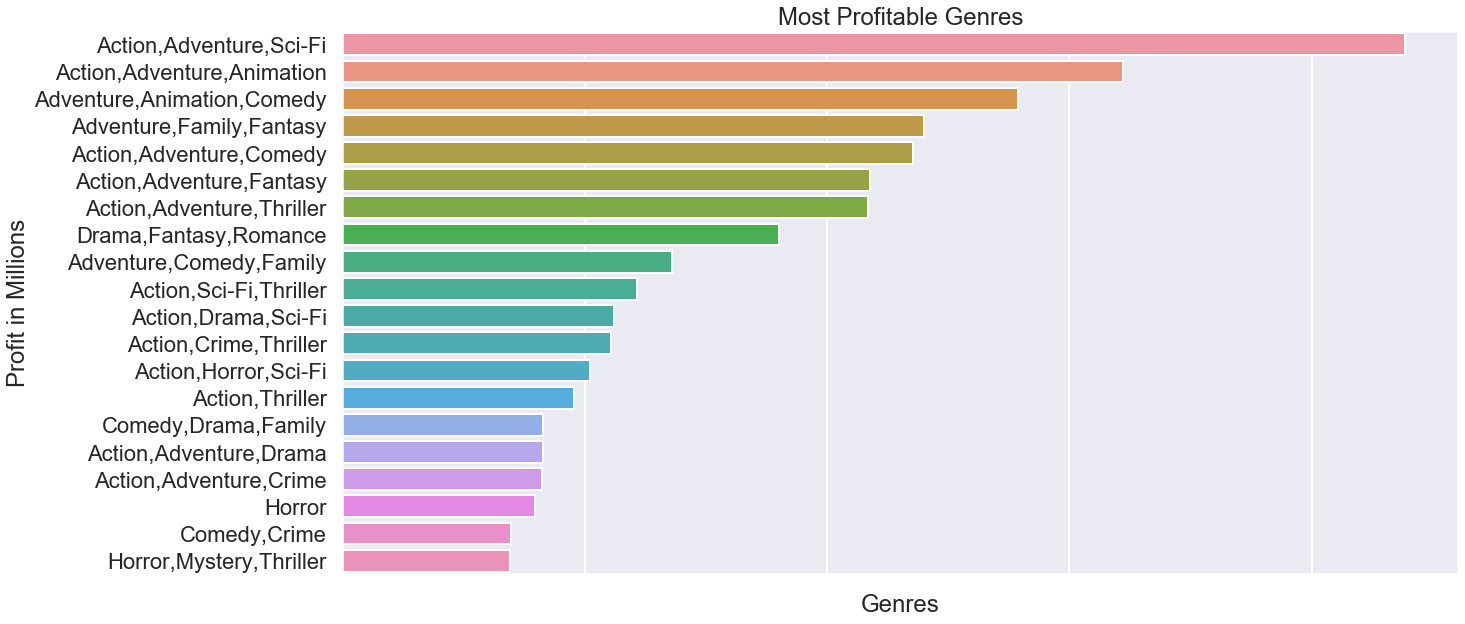

In [15]:
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
genresChart = sns.barplot(data=final_genre_table, y='genres',x='avg_profit')
genresChart.set_xticklabels(genresChart.get_xticklabels(), rotation=45, horizontalalignment='right')
genresChart.set(title = 'Most Profitable Genres', xlabel='Genres', ylabel='Profit in Millions')

In [16]:
#Finds correlation between average rating and profit
rating_clean = pysqldf('''select averagerating, profit / 1000000 as profit_in_milions from df''')
rating_clean.corr()

,averagerating,profit_in_milions
averagerating,1.000000,0.173084
profit_in_milions,0.173084,1.000000


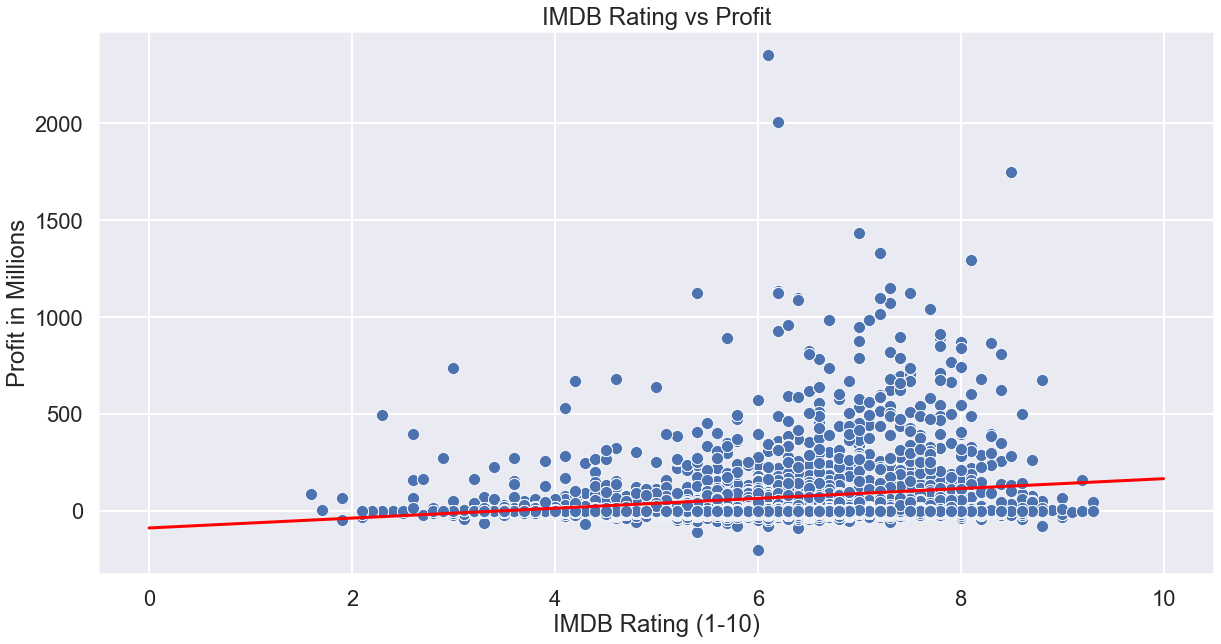

In [17]:
#Plot imdb rating vs profit along with trend line
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
ratingsChart = sns.scatterplot(data=rating_clean, x='averagerating',y='profit_in_milions')
ratingsChart.set(title = 'IMDB Rating vs Profit', xlabel='IMDB Rating (1-10)', ylabel='Profit in Millions')
x = rating_clean.averagerating
y = rating_clean.profit_in_milions
p = np.poly1d(np.polyfit(x,y,1))
xp = np.linspace(0,10,100)
ratingsChart.plot(xp,p(xp), color = 'red')

In [18]:
print(len(df[{'runtime_minutes', 'profit'}]))
print(df[{'runtime_minutes', 'profit'}].isna().sum())
runtime_clean = df[{'runtime_minutes', 'profit'}].dropna()
runtime_clean.profit = runtime_clean.profit /1000000
len(runtime_clean)
runtime_clean.corr()

27145
runtime_minutes    977
profit               0
dtype: int64


,runtime_minutes,profit
runtime_minutes,1.000000,0.189827
profit,0.189827,1.000000


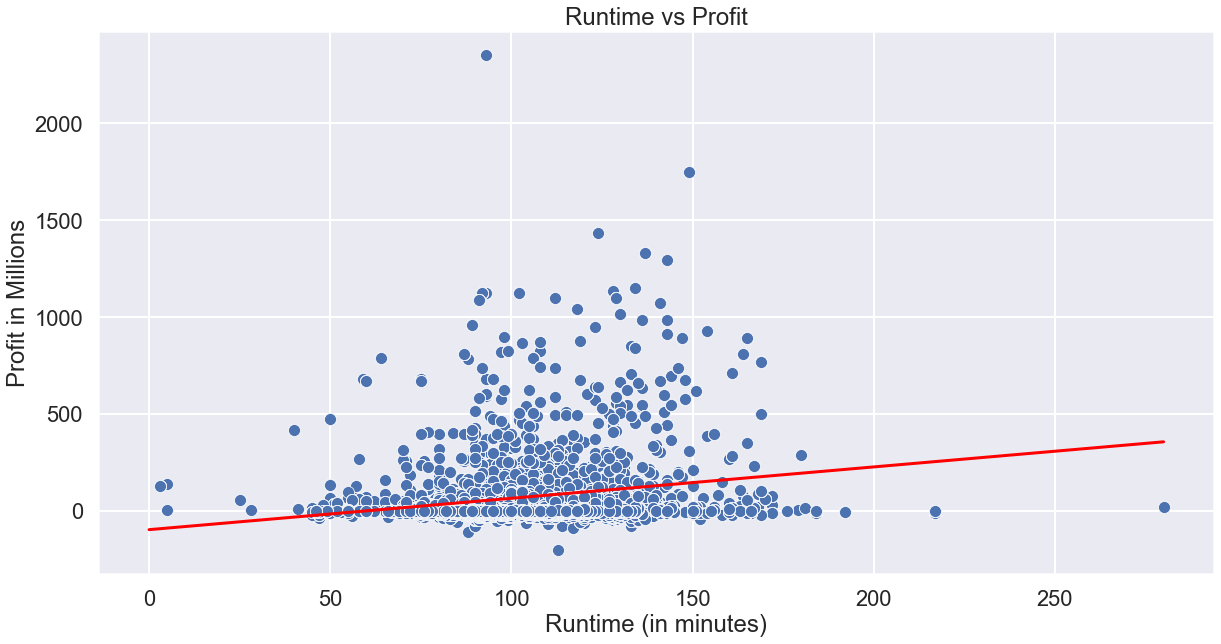

In [19]:
#Plot imdb rating vs profit along with trend line
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
runtimeChart = sns.scatterplot(data=runtime_clean, x='runtime_minutes',y='profit')
runtimeChart.set(title = 'Runtime vs Profit', xlabel='Runtime (in minutes)', ylabel='Profit in Millions')
x = runtime_clean.runtime_minutes
y = runtime_clean.profit
p = np.poly1d(np.polyfit(x,y,1))
xp = np.linspace(0,280,100)
runtimeChart.plot(xp,p(xp), color = 'red')

In [20]:
#Creates table of Actors and average profit with number of movies
producers = pysqldf('''select primary_name, avg(profit) / 1000000 as avg_profit, count(primary_name) as num_movies
           from df
           group by primary_name
           having count(primary_title) > 10 and (category == 'director' or category == 'producer')  
           order by avg(profit) desc
           limit 20''')

[Text(0, 0.5, 'Profit in Millions'),
 Text(0.5, 0, 'Producer Names'),
 Text(0.5, 1.0, 'Most Profitable Producers')]

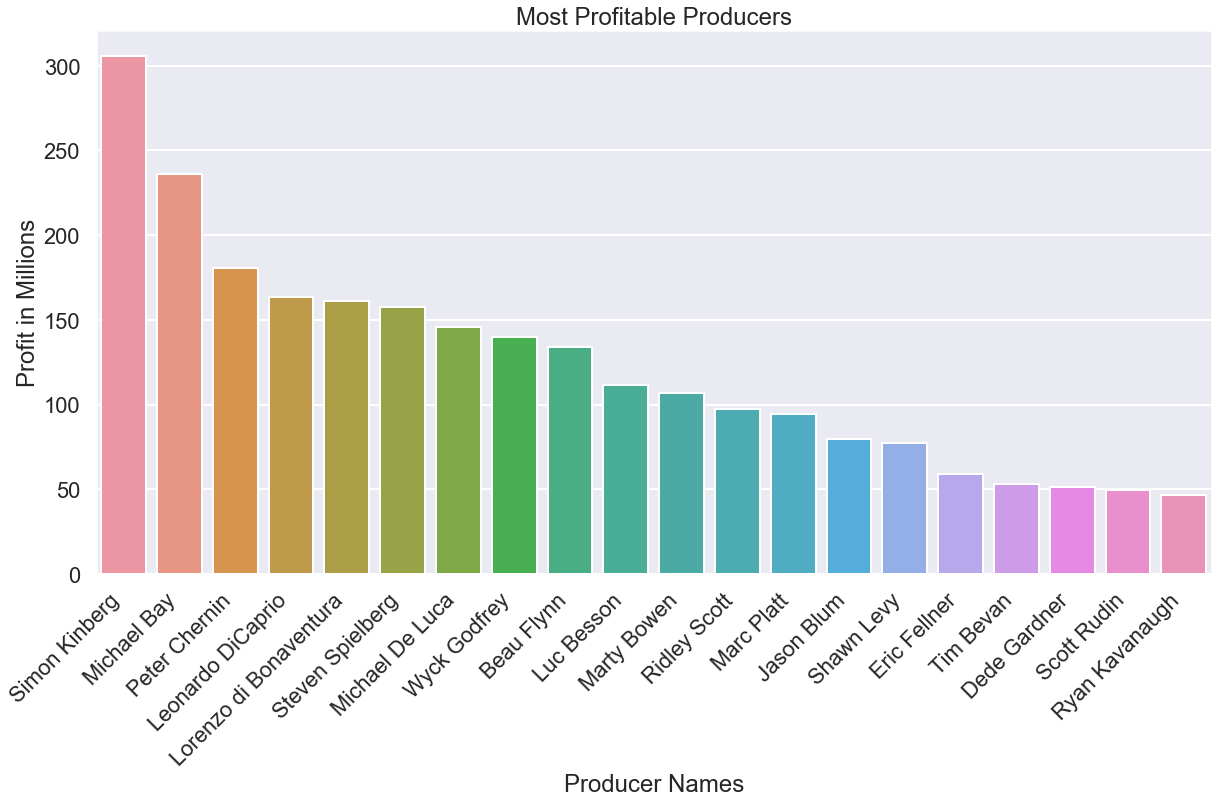

In [21]:
#Charts most profitable producer/director
sns.set(style = 'darkgrid', context = 'poster')
plt.figure(figsize=(20,10))
producersChart = sns.barplot(data=producers, x='primary_name', y='avg_profit')
producersChart.set_xticklabels(producersChart.get_xticklabels(), rotation=45, horizontalalignment='right')
producersChart.set(title = 'Most Profitable Producers', xlabel='Producer Names', ylabel='Profit in Millions')

In [22]:
months = pysqldf('''select release_month, avg(profit) / 1000000 as avg_profit
                    from df
                    group by release_month
                    order by avg_profit desc''')

[Text(0, 0.5, 'Avg Profit in Millions'),
 Text(0.5, 0, 'Months'),
 Text(0.5, 1.0, 'Most Profitable Months')]

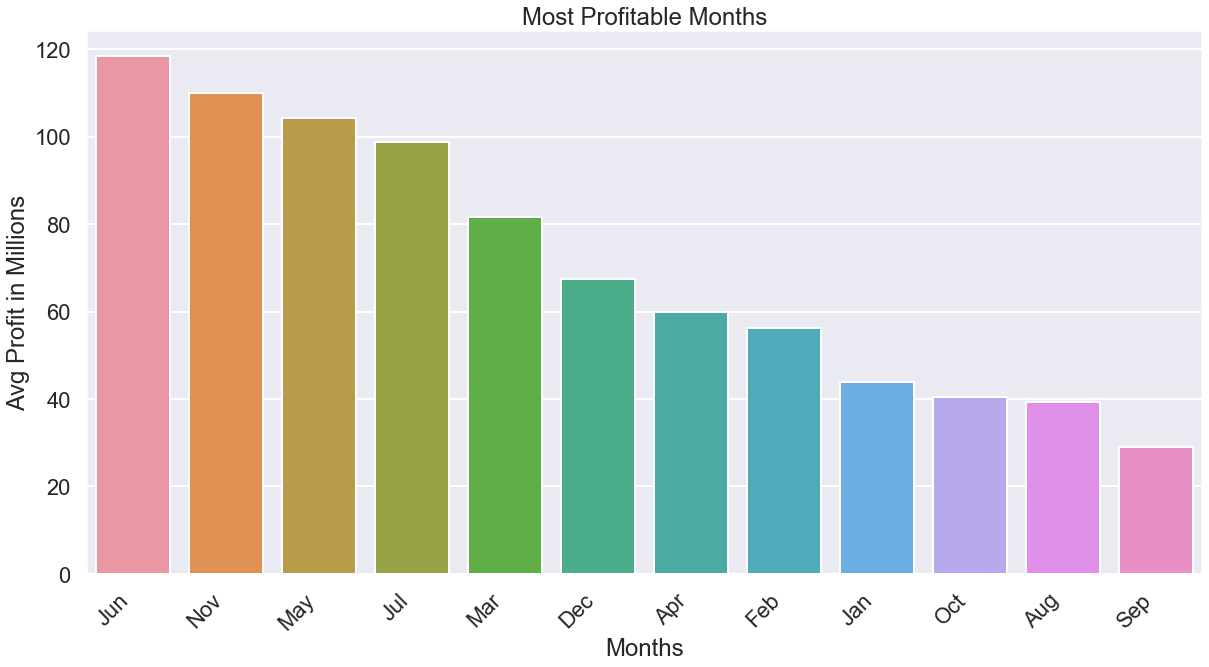

In [23]:
#Charts most profitable producer/director
sns.set(style = 'darkgrid', context = 'poster')
plt.figure(figsize=(20,10))
monthsChart = sns.barplot(data=months, x='release_month', y='avg_profit')
monthsChart.set_xticklabels(monthsChart.get_xticklabels(), rotation=45, horizontalalignment='right')
monthsChart.set(title = 'Most Profitable Months', xlabel='Months', ylabel='Avg Profit in Millions')


In [24]:
profit_budget_cor = pysqldf('''select production_budget / 1000000 as production_budget, profit / 1000000 as profit
                                from df
                                group by primary_title
                                having production_budget > 1000000''')
profit_budget_cor.corr()

,production_budget,profit
production_budget,1.000000,0.661094
profit,0.661094,1.000000


[Text(0, 0.5, 'Profit (in Milions)'),
 Text(0.5, 0, 'Production Budget (in Milions)'),
 Text(0.5, 1.0, 'Budget vs Profit')]

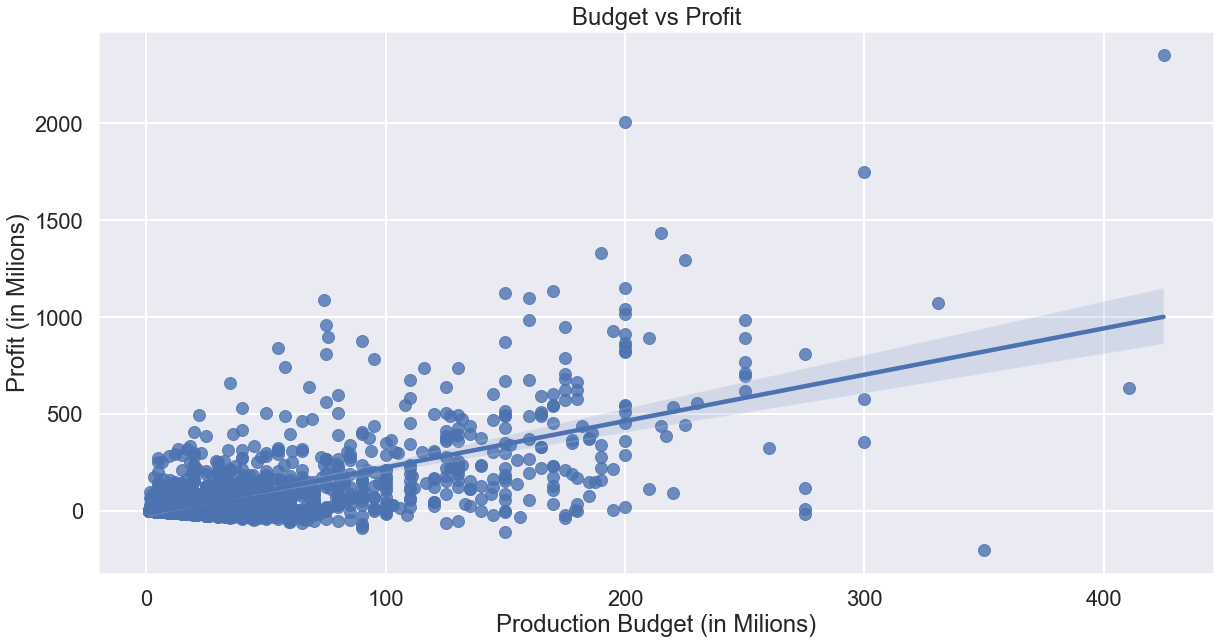

In [25]:
sns.set(style="darkgrid", context  = 'poster')
plt.figure(figsize=(20,10))
profit_budget_cor_chart = sns.regplot(data=profit_budget_cor, x='production_budget',y='profit')
profit_budget_cor_chart.set(title = 'Budget vs Profit', xlabel='Production Budget (in Milions)', ylabel='Profit (in Milions)')